# NBA Shots Taken 2014-15

#### Import Python Packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(color_codes=True)

In [2]:
from src.shot_functions import *

## Exploratory Data Analysis

### EDA By Spark SQL

#### Import Spark Packages

In [3]:
import json             # for parsing json formatted data
import csv              # for the split_csvstring function from Part 3.2.2
try:                    # Python 3 compatibility
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import os               # for accessing env variables for AWS credentials


In [4]:
import pyspark as ps

In [5]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
sc = spark.sparkContext

#### Shots Spark Dataframe

In [6]:
# read csv file into DataFrame
sdf = spark.read.csv('data/clean_shots_data.csv',
                      header=True,       # use headers or not
                      quote='"',         # char for quotes
                      sep=",",           # char for separation
                      inferSchema=True)

In [7]:
sdf.printSchema()

root
 |-- GAME_ID: integer (nullable = true)
 |-- SHOT_NUMBER: integer (nullable = true)
 |-- PERIOD: integer (nullable = true)
 |-- GAME_CLOCK: integer (nullable = true)
 |-- SHOT_CLOCK: double (nullable = true)
 |-- DRIBBLES: integer (nullable = true)
 |-- TOUCH_TIME: double (nullable = true)
 |-- SHOT_DIST: double (nullable = true)
 |-- CLOSE_DEF_DIST: double (nullable = true)
 |-- PTS_TYPE: integer (nullable = true)
 |-- SHOT_RESULT: string (nullable = true)
 |-- FGM: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- player_name: string (nullable = true)



In [8]:
sdf.createOrReplaceTempView('shots')

In [9]:
# Number of games
query = '''SELECT COUNT(DISTINCT GAME_ID)
           FROM shots
        '''

spark.sql(query).show()

+-----------------------+
|count(DISTINCT GAME_ID)|
+-----------------------+
|                    896|
+-----------------------+



In [10]:
# Number of players
query1 = '''SELECT COUNT(DISTINCT player_name)
            FROM shots
         '''

spark.sql(query1).show(5)

+---------------------------+
|count(DISTINCT player_name)|
+---------------------------+
|                        281|
+---------------------------+



In [11]:
# Player with the most shots
query1 = '''SELECT player_name, COUNT(player_name)
            FROM shots
            WHERE PTS_TYPE =3
            AND FGM=1
            GROUP BY player_name
            ORDER BY COUNT(player_name) DESC
         '''

spark.sql(query1).show(5)

+---------------+------------------+
|    player_name|count(player_name)|
+---------------+------------------+
|  stephen curry|               181|
|  klay thompson|               171|
|wesley matthews|               165|
|    kyle korver|               154|
|   james harden|               143|
+---------------+------------------+
only showing top 5 rows



In [12]:
# Player with the most made shots
query1 = '''SELECT player_name, COUNT(player_name)
            FROM shots
            WHERE FGM=1
            GROUP BY player_name
            ORDER BY COUNT(player_name) DESC
         '''

spark.sql(query1).show(5)

+-------------+------------------+
|  player_name|count(player_name)|
+-------------+------------------+
|stephen curry|               454|
| lebron james|               451|
|   mnta ellis|               444|
| james harden|               443|
|klay thompson|               435|
+-------------+------------------+
only showing top 5 rows



In [13]:
# Player with the most missed shots
query1 = '''SELECT player_name, COUNT(player_name)
            FROM shots
            WHERE FGM=0
            GROUP BY player_name
            ORDER BY COUNT(player_name) DESC
         '''

spark.sql(query1).show(5)

+-----------------+------------------+
|      player_name|count(player_name)|
+-----------------+------------------+
|     james harden|               542|
|       mnta ellis|               536|
|lamarcus aldridge|               528|
|   damian lillard|               511|
|russell westbrook|               509|
+-----------------+------------------+
only showing top 5 rows



In [14]:
# 
query1 = '''SELECT player_name, CLOSE_DEF_DIST
            FROM shots
            WHERE CLOSE_DEF_DIST < 2
            AND PTS_TYPE=3
            ORDER BY CLOSE_DEF_DIST ASC
            
        
         '''

spark.sql(query1).show(5)

+----------------+--------------+
|     player_name|CLOSE_DEF_DIST|
+----------------+--------------+
|  damian lillard|           0.0|
|patrick beverley|           0.0|
| carmelo anthony|           0.0|
|     zach lavine|           0.0|
|     joe johnson|           0.0|
+----------------+--------------+
only showing top 5 rows



### Basic Data Information

#### Create Pandas Dataframe

In [60]:
df = pd.read_csv('data/clean_shots_data.csv')

In [61]:
df.columns

Index(['GAME_ID', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK',
       'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'PTS_TYPE',
       'SHOT_RESULT', 'FGM', 'PTS', 'player_name'],
      dtype='object')

In [17]:
df.describe()

,GAME_ID,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,PTS_TYPE,FGM,PTS
count,1.152350e+05,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000,115235.000000
mean,2.140045e+07,6.481078,2.469024,1412.162763,12.053789,2.098711,2.881979,13.745692,4.158551,2.263444,0.453274,1.001727
std,2.578098e+02,4.695427,1.138317,838.552072,5.440012,3.474870,2.958250,8.666428,2.723967,0.440503,0.497814,1.133819
min,2.140000e+07,1.000000,1.000000,3.000000,0.000000,0.000000,0.100000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,2.140023e+07,3.000000,1.000000,668.000000,8.000000,0.000000,0.900000,5.100000,2.300000,2.000000,0.000000,0.000000
50%,2.140045e+07,5.000000,2.000000,1402.000000,12.000000,1.000000,1.700000,14.200000,3.700000,2.000000,0.000000,0.000000
75%,2.140067e+07,9.000000,3.000000,2110.000000,16.000000,3.000000,3.900000,22.600000,5.300000,3.000000,1.000000,2.000000
max,2.140091e+07,37.000000,7.000000,3763.000000,23.900000,32.000000,24.900000,42.800000,53.200000,3.000000,1.000000,3.000000


#### Deeper Dive into the Data

In [18]:
total_count = 117936
made_shot_count = df.FGM[df.FGM==1].count()
miss_shot_count = df.FGM[df.FGM==0].count()
twopt_shot_count = df.PTS_TYPE[df.PTS_TYPE==2].count()
threept_shot_count = df.PTS_TYPE[df.PTS_TYPE==3].count()
twopt_shot_count, threept_shot_count

(84877, 30358)

In [19]:
# Percentage of 2 point shots taken
twopt_shot_count/total_count

0.7196869488536155

In [20]:
# Percentage of 3 point shots taken
threept_shot_count/total_count

0.2574107990774657

In [21]:
# Percentage of made shots
made_shot_count/total_count

0.4428927553927554

In [22]:
# Percentage of missed shots
miss_shot_count/total_count

0.5342049925383259

In [23]:
two = df[(df.PTS_TYPE == 2)]
three = df[(df.PTS_TYPE == 3)]

misstwo = two[(two.FGM == 0)]
madetwo = two[(two.FGM == 1)]

missthree = three[(three.FGM == 0)]
madethree = three[(three.FGM == 1)]

miss = df[(df.FGM == 0)]
made = df[(df.FGM == 1)]

In [24]:
twopt_made_count = made.PTS_TYPE[made.PTS_TYPE==2].count()
threept_made_count = made.PTS_TYPE[made.PTS_TYPE==3].count()

In [25]:
# Percentage of 2 point shots made
twopt_made_count/twopt_shot_count

0.4861741107720584

In [26]:
# Pecentage of 3 point shots made
threept_made_count/threept_shot_count

0.36128862243889587

In [27]:
madethree.SHOT_DIST.count()

10968

In [28]:
missthree.SHOT_DIST.count()

19390

### Graphs

''

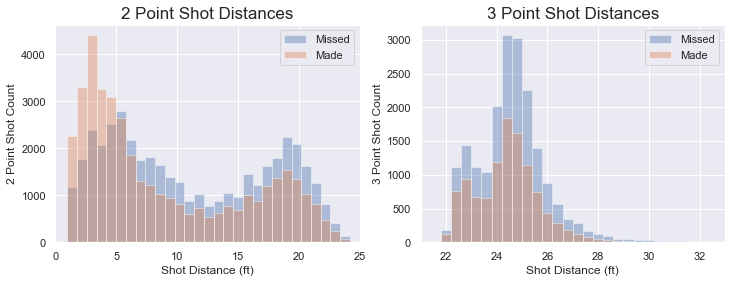

In [29]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(misstwo.SHOT_DIST, bins=np.arange(1, 100, .8), ax=axs[0], label='Missed', kde=False))
(sns.distplot(madetwo.SHOT_DIST, bins=np.arange(1, 100, .8), ax=axs[0], label='Made', kde=False)
    .set_title("2 Point Shot Distances",fontsize=17))

(sns.distplot(missthree.SHOT_DIST, bins=np.arange(1, 100, 0.4), ax=axs[1], label='Missed', kde=False))
(sns.distplot(madethree.SHOT_DIST, bins=np.arange(1, 100, 0.4), ax=axs[1], label='Made', kde=False)
    .set_title("3 Point Shot Distances",fontsize=17))

axs[0].set_xlabel('Shot Distance (ft)')
axs[0].set_ylabel('2 Point Shot Count')
axs[1].set_xlabel('Shot Distance (ft)')
axs[1].set_ylabel('3 Point Shot Count')

axs[0].set_xlim(0,25)
axs[1].set_xlim(21,33)

axs[0].legend()
axs[1].legend()
;

*Shot clock counts down from 24.0 seconds


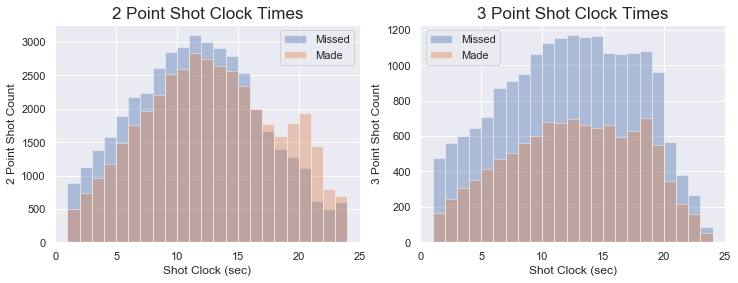

In [30]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(misstwo.SHOT_CLOCK, ax=axs[0], bins=range(1, 100, 1), label='Missed', kde=False))
(sns.distplot(madetwo.SHOT_CLOCK, ax=axs[0], bins=range(1, 100, 1), label='Made', kde=False)
    .set_title("2 Point Shot Clock Times",fontsize=17))

(sns.distplot(missthree.SHOT_CLOCK, ax=axs[1], bins=range(1, 100, 1), label='Missed', kde=False))
(sns.distplot(madethree.SHOT_CLOCK, ax=axs[1], bins=range(1, 100, 1), label='Made', kde=False)
    .set_title("3 Point Shot Clock Times",fontsize=17))

axs[0].set_xlabel('Shot Clock (sec)')
axs[0].set_ylabel('2 Point Shot Count')
axs[1].set_xlabel('Shot Clock (sec)')
axs[1].set_ylabel('3 Point Shot Count')

axs[0].set_xlim(0,25)
axs[1].set_xlim(0,25)

axs[0].legend()
axs[1].legend()
;

print('*Shot clock counts down from 24.0 seconds')

*152 shots (0.13%) with a defender 20 ft away (caps at 53 ft), NBA court is 94 by 50 feet


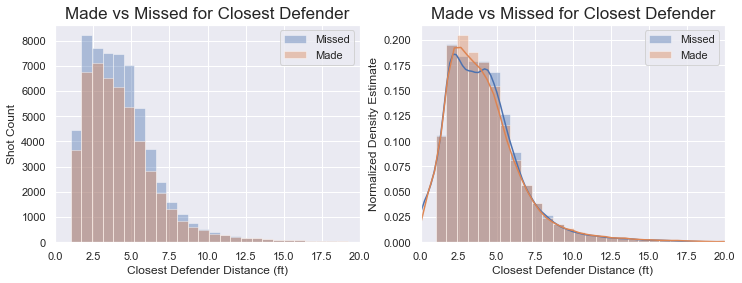

In [31]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(miss.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.7), ax=axs[0], label='Missed', kde=False))
(sns.distplot(made.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.7), ax=axs[0], label='Made', kde=False)
    .set_title("Made vs Missed for Closest Defender",fontsize=17))

(sns.distplot(miss.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.7), ax=axs[1], label='Missed'))
(sns.distplot(made.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.7), ax=axs[1], label='Made')
    .set_title("Made vs Missed for Closest Defender",fontsize=17))

axs[0].set_xlabel('Closest Defender Distance (ft)')
axs[0].set_ylabel('Shot Count')
axs[1].set_xlabel('Closest Defender Distance (ft)')
axs[1].set_ylabel('Normalized Density Estimate')

axs[0].set_xlim(0,20)
axs[1].set_xlim(0,20)


axs[0].legend()
axs[1].legend()
;
print('*152 shots (0.13%) with a defender 20 ft away (caps at 53 ft), NBA court is 94 by 50 feet')

''

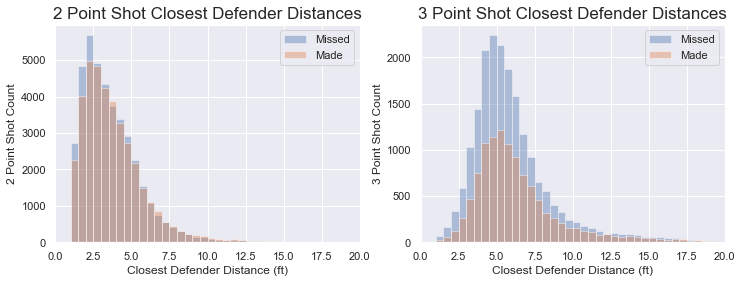

In [32]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(misstwo.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[0], label='Missed', kde=False))
(sns.distplot(madetwo.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[0], label='Made', kde=False)
    .set_title("2 Point Shot Closest Defender Distances",fontsize=17))

(sns.distplot(missthree.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[1], label='Missed', kde=False))
(sns.distplot(madethree.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[1], label='Made', kde=False)
    .set_title("3 Point Shot Closest Defender Distances",fontsize=17))

axs[0].set_xlabel('Closest Defender Distance (ft)')
axs[0].set_ylabel('2 Point Shot Count')
axs[1].set_xlabel('Closest Defender Distance (ft)')
axs[1].set_ylabel('3 Point Shot Count')

axs[0].set_xlim(0,20)
axs[1].set_xlim(0,20)

axs[0].legend()
axs[1].legend()
;

''

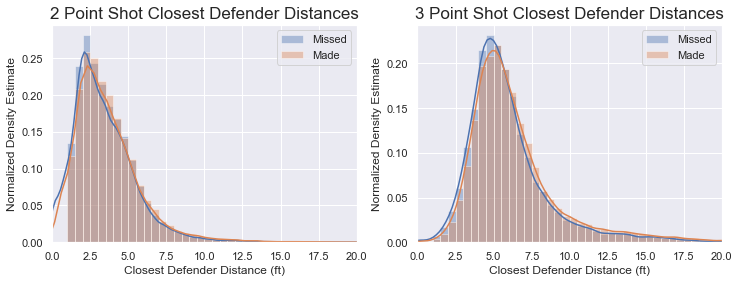

In [33]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(misstwo.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[0], label='Missed'))
(sns.distplot(madetwo.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[0], label='Made')
    .set_title("2 Point Shot Closest Defender Distances",fontsize=17))

(sns.distplot(missthree.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[1], label='Missed'))
(sns.distplot(madethree.CLOSE_DEF_DIST, bins=np.arange(1, 100, 0.5), ax=axs[1], label='Made')
    .set_title("3 Point Shot Closest Defender Distances",fontsize=17))

axs[0].set_xlabel('Closest Defender Distance (ft)')
axs[0].set_ylabel('Normalized Density Estimate')
axs[1].set_xlabel('Closest Defender Distance (ft)')
axs[1].set_ylabel('Normalized Density Estimate')

axs[0].set_xlim(0,20)
axs[1].set_xlim(0,20)

axs[0].legend()
axs[1].legend()
;

''

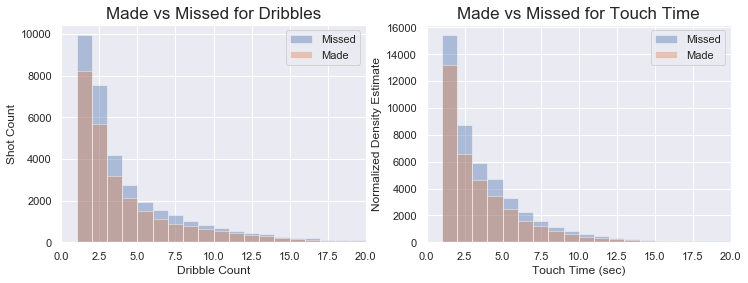

In [50]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs.flatten()

(sns.distplot(miss.DRIBBLES, bins=np.arange(1, 100, 1), ax=axs[0], label='Missed', kde=False))
(sns.distplot(made.DRIBBLES, bins=np.arange(1, 100, 1), ax=axs[0], label='Made', kde=False)
    .set_title("Made vs Missed for Dribbles",fontsize=17))

(sns.distplot(miss.TOUCH_TIME, bins=np.arange(1, 100, 1), ax=axs[1], label='Missed', kde=False))
(sns.distplot(made.TOUCH_TIME, bins=np.arange(1, 100, 1), ax=axs[1], label='Made', kde=False)
    .set_title("Made vs Missed for Touch Time",fontsize=17))

axs[0].set_xlabel('Dribble Count')
axs[0].set_ylabel('Shot Count')
axs[1].set_xlabel('Touch Time (sec)')
axs[1].set_ylabel('Normalized Density Estimate')

axs[0].set_xlim(0,20)
axs[1].set_xlim(0,20)


axs[0].legend()
axs[1].legend()
;

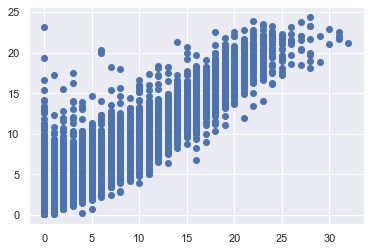

In [64]:
plt.scatter(miss.DRIBBLES,miss.TOUCH_TIME)

In [34]:
df2 = df.copy()

In [35]:
df2['DRIBBLE_RATE'] = df2['DRIBBLES']/df2['TOUCH_TIME']

In [36]:

cut = ['SHOT_NUMBER', 'GAME_CLOCK','SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
          'SHOT_DIST', 'CLOSE_DEF_DIST', 'FGM','DRIBBLE_RATE']

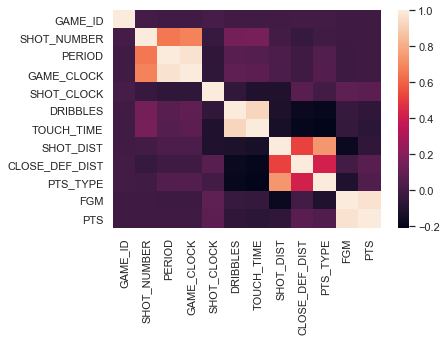

In [37]:
sns.heatmap(df.corr());

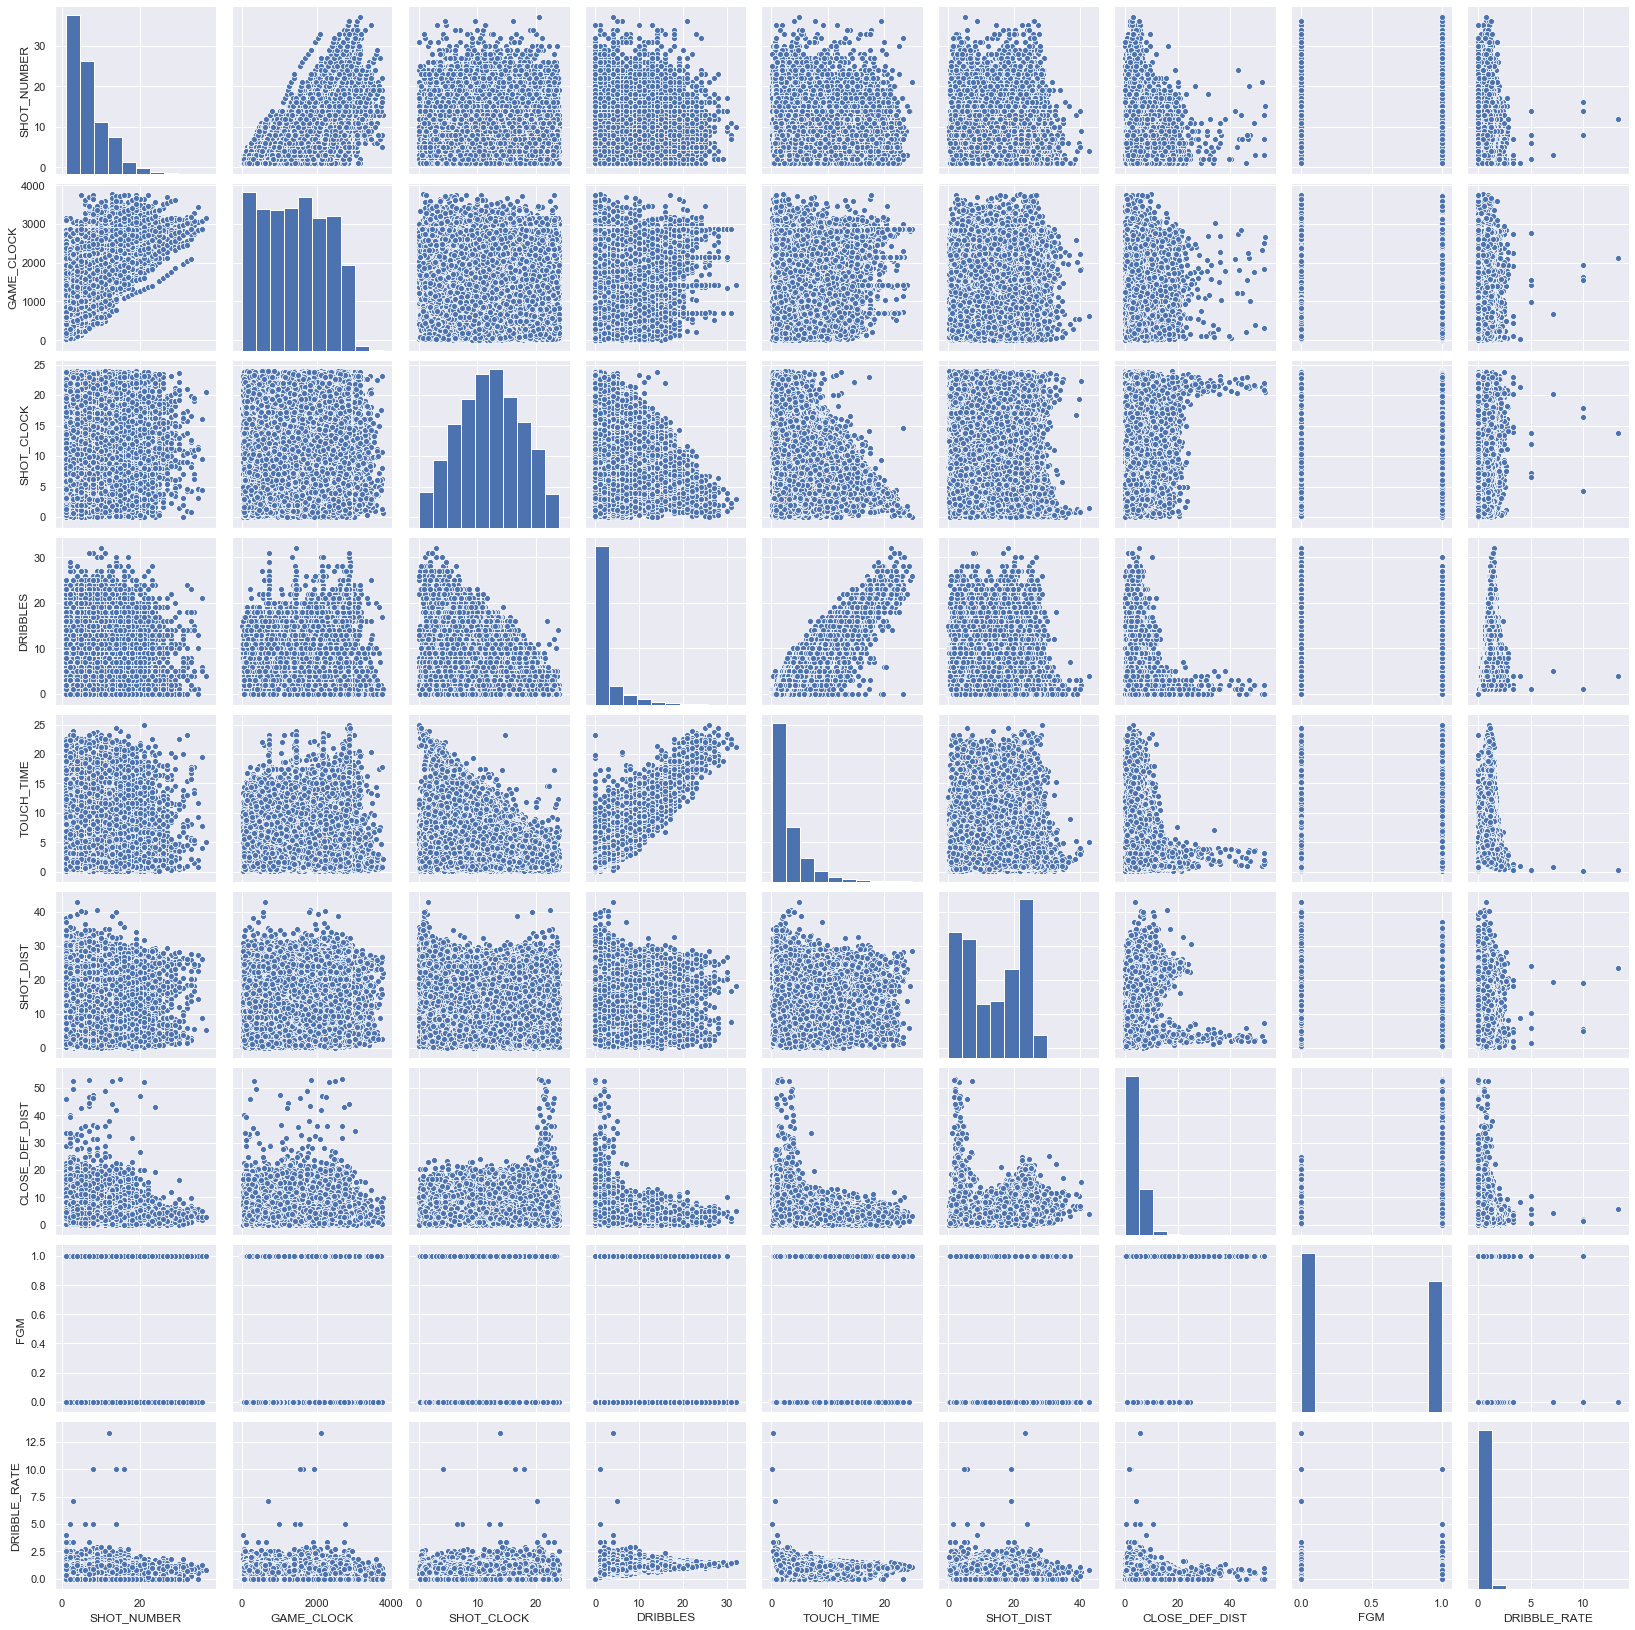

In [38]:
sns.pairplot(df2[cut])

### Hypothesis Testing

In [53]:
# Welch t-test (requires dist to be normal)
def welch_test_statistic(sample_1, sample_2):
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + \
                        (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)

def welch_satterhwaithe_df(sample_1, sample_2):
    ss1 = len(sample_1)
    ss2 = len(sample_2)
    print(ss1,ss2)
    df = (
        ((np.var(sample_1)/ss1 + np.var(sample_2)/ss2)**(2.0)) / 
        ((np.var(sample_1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample_2)/ss2)**(2.0)/(ss2 - 1))
    )
    return df

In [54]:
test_statistic = welch_test_statistic(missthree.CLOSE_DEF_DIST,madethree.CLOSE_DEF_DIST)
degf = welch_satterhwaithe_df(missthree.CLOSE_DEF_DIST,madethree.CLOSE_DEF_DIST)
CTR_ttest = stats.t(degf)

19390 10968


In [55]:
p_value = CTR_ttest.cdf(test_statistic) + (1 - CTR_ttest.cdf(-test_statistic))
p_value

2.0085923046190794e-29

In [56]:
p1 = (1 - CTR_ttest.cdf(welch_test_statistic(madethree.CLOSE_DEF_DIST,missthree.CLOSE_DEF_DIST)))
p2 = (1 - CTR_ttest.cdf(test_statistic))
p1,p2

(0.0, 1.0)

In [57]:
stats.ttest_ind(misstwo.CLOSE_DEF_DIST,madetwo.CLOSE_DEF_DIST)

Ttest_indResult(statistic=-15.752081916734005, pvalue=7.975867189774046e-56)

In [58]:
stats.ttest_ind(missthree.CLOSE_DEF_DIST,madethree.CLOSE_DEF_DIST)

Ttest_indResult(statistic=-11.447856928426187, pvalue=2.7813643247998333e-30)

In [59]:
stats.mannwhitneyu(madethree.CLOSE_DEF_DIST,missthree.CLOSE_DEF_DIST, alternative='greater')

MannwhitneyuResult(statistic=114962756.0, pvalue=2.987073636124732e-32)

u-test for madethree close def dist < missthree close def dist: p-value = 3e-32,   
Reject the null that closest defender's distance for a made three def dist is less than missed three.